
# Gaussian process regression (GPR) on Mauna Loa CO2 data.

Adapted from http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html.

The data consists of the monthly average atmospheric
CO2 concentrations (in parts per million by volume (ppmv)) collected at the
Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to
model the CO2 concentration as a function of the time t.

If $k1, k2: \mathbb{X} \times \mathbb{X} \to \mathbb{R}$ are positive semidefinite, so are:
$$k1+k2, k1*k2$$

So we can build up a kernel that incorporates prior knowledge about the problem.



In [1]:
import pandas, datetime, numpy
df = pandas.read_csv('mauna-loa-atmospheric-co2.csv') 
train_index = df['year'] < 1990
train_ys = df.loc[train_index, 'co2']
test_ys = df.loc[~train_index, 'co2']
train_xs = []
for row in df.loc[train_index].itertuples():
    train_xs.append(datetime.date(row[1], row[ 2], row[ 3]).toordinal())
test_xs = []
for row in df.loc[~train_index].itertuples():
    test_xs.append(datetime.date(row[1], row[ 2], row[ 3]).toordinal())
df.describe()

year        month          day       weight    flag          co2
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.0  2225.000000
mean   1980.026067     6.568989    15.725393     5.816180     0.0   340.142247
std      12.495512     3.451596     8.796644     1.381698     0.0    17.003885
min    1958.000000     1.000000     1.000000     1.000000     0.0   313.000000
25%    1969.000000     4.000000     8.000000     5.000000     0.0   324.800000
50%    1980.000000     7.000000    16.000000     6.000000     0.0   338.300000
75%    1991.000000    10.000000    23.000000     7.000000     0.0   354.800000
max    2001.000000    12.000000    31.000000     7.000000     0.0   373.900000

In [11]:
from matplotlib import pyplot as plt
#from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared


train_X = numpy.asarray(train_xs).reshape(-1, 1)


def fit(kernel):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0, 
          # to suppress fitting kernel optimizer=None, 
          normalize_y=True)
    gp.fit(train_X, train_ys)

    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta))

    X_ = numpy.linspace(X.min(), X.max() + 3650, 1000)[:, numpy.newaxis]
    y_pred, y_std = gp.predict(X_, return_std=True)
    # Illustration
    plt.figure()
    plt.fill_between(X_[:, 0], y_pred + y_std,y_pred - y_std,
                     alpha=1, color='grey', label='sigma')
    plt.plot(X_, y_pred, label='predicted', linewidth=2)
    plt.scatter(train_X, train_ys, c='black', s=1, label='training')
    plt.scatter(test_xs, test_ys, c='red', s=1, label='test')
    plt.xlim(X_.min(), X_.max())
    plt.xlabel("Date")
    plt.xticks([datetime.date(year, 1, 1).toordinal() for year in range(1960, 2010, 10)], 
               [str(year) for year in range(1960, 2010, 10)])
    plt.ylabel(r"CO2 in ppm")
    plt.title(r"Atmospheric CO2 concentration at Mauna Loa")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return gp.kernel_

## Fit the long term trend
Use an RBF kernel with a long time base.


Learned kernel: WhiteKernel(noise_level=4.26) + 51.3**2 * RBF(length_scale=1.89e+04)
Log-marginal-likelihood: -3442.484


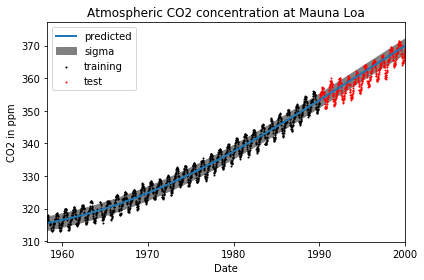

In [12]:
kernel1 = fit(
    # adding a noise term allows variation and avoids numerical issues 
    WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, numpy.inf)) 
    # smoothing
    + 50.0**2 * RBF(length_scale=7.0*365)  
)

## Also fit the seasonal component
To do this, we add a periodic term to the kernel:
$$e^{-2 sin^2(\pi \omega d(x_i, x_j))/ \sigma^2}$$
We have strong prior knowledge of the periodicity.


Learned kernel: WhiteKernel(noise_level=0.344) + 108**2 * RBF(length_scale=2.97e+04) + 3.27**2 * ExpSineSquared(length_scale=1.61, periodicity=364)
Log-marginal-likelihood: -1457.297


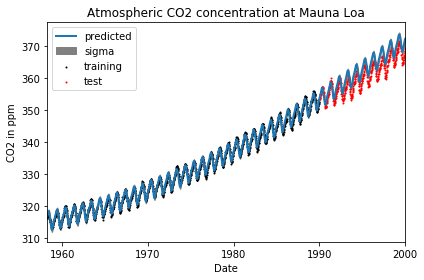

In [14]:
kernel2 = fit( kernel1 
        +     2.0**2  * ExpSineSquared(
            length_scale=3, periodicity=364.25,
            periodicity_bounds="fixed")  # seasonal component
)

By adding more terms to the kernel, it is possible to improve the fit. See:
Section 5.4.3 of "Gaussian Processes for Machine
Learning" [RW2006]. 

[Next](Mercer.ipynb)

Copyright STFC 2018 Author Chris Morris